# Business Problem Understanding

## Context
Sebuah hotel di Portugal ingin mengurangi jumlah pembatalan reservasi yang telah dibuat oleh pelanggan. Pihak hotel ingin mengetahui faktor apa saja yang dapat mempengaruhi kemungkinan seseorang untuk membatalkan reservasi yang sudah dibuat sebelumnya. Selain itu pihak hotel juga ingin mencoba strategi baru dalam mengatasi pembatalan reservasi dengan menghubungi pelanggan secara langsung. Pihak hotel memiliki data booking yang pernah dibuat oleh pelanggan, dengan data yang terkait dengan informasi pribadi pelanggan sudah dibuang dari dataset.

Target:\
0: tidak membatalkan reservasi\
1: membatalkan reservasi

### Problem Statement
Pembatalan yang dilakukan oleh pelanggan berpotensi menimbulkan kerugian bagi hotel. Kerugian yang dialami dapat berupa kerugian finansial, seperti kamar yang kosong padahal seharusnya berpotensi untuk ditawarkan pengguna lain, atau kerugian dikarenakan adanya biaya-biaya administrasi yang harus dikeluarkan oleh hotel jika perlu melakukan pengembalian dana kepada pelanggan.\
\
Selain kerugian finansial, hotel juga berpotensi mengalami kerugian dari sisi pemasaran. Hal ini dikarenakan OTA (Online Travel Agent) seperti booking.com mengecek hotel mana yang sering mendapatkan pembatalan dari pelanggan, dan berpotensi menurunkan reputasi hotel tersebut. Selain itu, permasalahan pembatalan ini juga membuat pihak hotel sulit membuat perencanaan *occupancy rate* hotel, serta dapat menimbulkan pekerjaan tambahan bagi para staffnya.

Selama ini, pihak hotel telah membuat kebijakan-kebijakan terkait pembatalan untuk mengurangi dampak kerugian yang ditimbulkan dari pembatalan, seperti misalnya kebijakan pengembalian dana paling lambat 14 hari sebelum check-in, pembebasan biaya perubahan detail booking, pemberian voucher, dan lain-lain. \
\
Selain penyesuaian kebijakan pembatalan, hotel pun sudah menerapkan strategi *'overbooking'*, yaitu mengantisipasi pembatalan dengan cara membuka slot reservasi kamar lebih banyak daripada yang sebenarnya tersedia di hotel. Strategi ini diterapkan terutama pada tanggal-tanggal *high season* seperti masa liburan pada musim panas.\
\
Namun meskipun kebijakan terkait pembatalan telah diberlakukan, tetap ada pelanggan yang membatalakan reservasinya, dan meskipun *overbooking* membantu mengisi kamar-kamar yang kosong karena dibatalkan, namun strategi ini dapat berisiko bagi pihak hotel, sehingga tetap perlu untuk menggunakan strategi lain untuk mengurangi pembatalan yang dilakukan oleh pelanggan.

### Goals

Tujuan utama dari dibuatnya prediksi pembatalan reservasi seorang pelanggan yaitu pihak hotel ingin mencoba strategi baru dengan  mengirimkan pesan terpersonalisasi melalui e-mail atau menghubungi pelanggan melalui telepon untuk mengonfirmasi detail pesanan yang telah dibuat kepada pelanggan yang berpotensi akan membatalkan reservasi. Dengan menghubungi pelanggan secara langsung, pelanggan akan merasakan semacam koneksi/ikatan dengan pihak hotel, sehingga kemungkinan untuk membatalkan pesanannya akan menurun.

### Analytic Approach
Yang akan dilakukan adalah melakukan analisis data untuk dapat menemukan pola pelanggan yang berpotensi akan membatalkan reservasi dan tidak akan membatalkan. Setelah itu akan dibuat model klasifikasi yang dapat memprediksi kemungkinan seorang pelanggan dalam membatalkan reservasinya.

### Metric Evaluation
Positive case: pelanggan membatalkan pesanan

Type 1 error : False Positive  
Konsekuensi: Membuang *resources* 

Type 2 error : False Negative  
Konsekuensi: Kamar kosong karena dibatalkan oleh pelanggan, sehingga revenue menurun.

Jika banyak terjadi type 1 error dimana banyak pelanggan yang diprediksi akan membatalkan reservasi padahal aktualnya tidak, maka pihak hotel akan membuang *resource* berupa tenaga staff hotel yang seharusnya bisa menghubungi pelanggan yang memang ingin membatalkan.\
\
Jika banyak terjadi type 2 error dimana banyak pelanggan yang diprediksi tidak membatalkan reservasi padahal aktualnya membatalkan, maka kemungkinan yang terjadi adalah kamar yang menjadi kosong karena dibatalkan oleh pelanggan. Hal ini dapat membuat pemasukan hotel menurun.\
\
Berdasarkan konsekuensinya, maka sebisa mungkin yang akan dilakukan adalah membuat model yang dapat memprediksi sebanyak mungkin case positive (pelanggan membatalkan reservasi). Selain itu, yang perlu dipertimbangkan dalam konteks ini adalah perlu memastikan bahwa *resource* yang digunakan efektif menangani masalah (menghubungi orang yang memang berniat membatalkan, bukan yang tidak berniat membatalkan), karena jika *resource* ini digunakan secara tidak efektif pun pada akhirnya berpengaruh pada revenue hotel. Jika pelanggan yang berniat membatalkan tidak dihubungi oleh pihak hotel, tentu juga berdampak buruk pada revenue hotel, namun untuk saat ini pihak hotel sudah memiliki beberapa strategi untuk mengatasi hal tersebut, dan hotel ingin berfokus untuk mencoba strategi baru dengan menghubungi pelanggan secara efektif. Jadi yang diinginkan adalah prediksi true positive sebanyak mungkin serta false positive sesedikit mungkin. Jadi nanti metric utama yang akan digunakan adalah roc-auc. 

In [1]:
# Library

import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
from IPython.display import display

# Feature Engineering
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
import category_encoders as ce

# Model Selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_curve, roc_auc_score,RocCurveDisplay

# Imbalance Dataset
#from imblearn.pipeline import Pipeline
#from imblearn.over_sampling import RandomOverSampler

# Ignore Warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Set max columns
pd.set_option('display.max_columns', None)

# Data Understanding

- country: Country of origin.
- market_segment: Market segment designation. 
- previous_cancellations: Number of previous bookings that were cancelled by the customer prior to the current booking.
- booking_changes: Number of changes/amendments made to the booking from the moment the booking was entered on the PMS until the moment of check-in or cancellation.
- deposit_type: Indication on if the customer made a deposit to guarantee the booking. 
- days_in_waiting_list: Number of days the booking was in the waiting list before it was confirmed to the customer.
- customer_type: Type of booking.
- reserved_room_type: Code of room type reserved. Code is presented instead of designation for anonymity reasons.
- required_car_parking_space: Number of car parking spaces required by the customer.
- total_of_special_request: Number of special requests made by the customer (e.g. twin bed or high floor).
- is_canceled: Value indicating if the booking was canceled (1) or not (0).


In [2]:
#Load Dataset
df = pd.read_csv("data_hotel_booking_demand.csv")
df.sample(10)

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
20317,FRA,Online TA,0,2,No Deposit,0,Transient,A,0,0,0
24986,PRT,Online TA,0,0,No Deposit,0,Transient,A,0,0,1
17242,PRT,Online TA,0,0,No Deposit,0,Transient,E,0,1,1
79440,CHN,Online TA,0,0,No Deposit,0,Transient,A,0,1,1
7758,PRT,Online TA,0,0,No Deposit,0,Transient,A,0,0,0
15481,FRA,Online TA,0,0,No Deposit,0,Transient,D,0,1,0
13114,GBR,Online TA,0,0,No Deposit,0,Transient,D,0,1,1
77888,LTU,Online TA,0,1,No Deposit,0,Transient,A,0,1,0
12070,DEU,Offline TA/TO,0,2,No Deposit,0,Transient-Party,A,0,1,0
41643,BEL,Online TA,0,0,No Deposit,0,Transient,A,0,1,0


In [3]:
# Melihat jumlah data dan tipe data masing-masing kolom
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83573 entries, 0 to 83572
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   country                      83222 non-null  object
 1   market_segment               83573 non-null  object
 2   previous_cancellations       83573 non-null  int64 
 3   booking_changes              83573 non-null  int64 
 4   deposit_type                 83573 non-null  object
 5   days_in_waiting_list         83573 non-null  int64 
 6   customer_type                83573 non-null  object
 7   reserved_room_type           83573 non-null  object
 8   required_car_parking_spaces  83573 non-null  int64 
 9   total_of_special_requests    83573 non-null  int64 
 10  is_canceled                  83573 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 7.0+ MB


# Data Cleaning

## Missing Values
Berdasarkan *data understanding* yang telah dilakukan, hanya satu kolom yang memiliki *missing value*, yaitu kolom `country`. Data yang kosong sebanyak 351 data. \
Data yang kosong ini kemungkinan besar tidak terisi karena asal negara pelanggan tidak diketahui. Kemungkinan data ini kosong dikarenakan pelanggan tersebut tidak memiliki kewarganegaraan (*stateless*) sangat kecil karena situasi *stateless* umumnya terjadi pada kelompok minoritas dimana sedang terjadi konflik atau masalah pada sistem kewarganegaraan di negaranya. Maka data yang kosong akan diisi dengan 'XXX'.

In [4]:
df.isna().sum()/df.shape[0]*100

country                        0.419992
market_segment                 0.000000
previous_cancellations         0.000000
booking_changes                0.000000
deposit_type                   0.000000
days_in_waiting_list           0.000000
customer_type                  0.000000
reserved_room_type             0.000000
required_car_parking_spaces    0.000000
total_of_special_requests      0.000000
is_canceled                    0.000000
dtype: float64

Data yang kosong pada kolom `country` hanya sebesar 0.4% dari keseluruhan data.

In [5]:
#Isi null pake 'XXX'
df['country'].fillna(value='XXX', inplace = True)

## Inspecting Columns
Selain membersihkan *missing value*, *value* dari masing-masing kolom juga perlu dicek. Dengan memeriksa *value* dari masing-masing kolom, dapat diperoleh pemahaman lebih jauh mengenai masing-masing kolom, dan jika ada data yang belum bersih (misal terdapat *typo* atau kesalahan input lainnya), maka data tersebut dapat ditangani sebelum dilakukan tahapan analisis lebih lanjut.

In [6]:
display(df.describe(), df.describe(include='object'))

,previous_cancellations,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,is_canceled
count,83573.000000,83573.000000,83573.000000,83573.000000,83573.000000,83573.000000
mean,0.086798,0.220897,2.330561,0.062999,0.573211,0.368277
std,0.841011,0.648635,17.673051,0.246919,0.795163,0.482340
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,26.000000,21.000000,391.000000,8.000000,5.000000,1.000000


,country,market_segment,deposit_type,customer_type,reserved_room_type
count,83573,83573,83573,83573,83573
unique,163,8,3,4,10
top,PRT,Online TA,No Deposit,Transient,A
freq,34097,39460,73352,62732,60041


In [7]:
pd.set_option('display.max_colwidth', 1)
# Isi masing-masing kolom
listItem = []
for col in df.columns :
    listItem.append( [col, df[col].nunique(), df[col].unique()])

tabel1Desc = pd.DataFrame(columns=['Column Name', 'Number of Unique', 'Unique Sample'],
                     data=listItem)
tabel1Desc

,Column Name,Number of Unique,Unique Sample
0,country,163,"[IRL, FRA, PRT, NLD, ESP, UMI, CN, LUX, BRA, BEL, JPN, DEU, ITA, CHE, GBR, AGO, SRB, COL, CHN, SWE, AUT, CIV, CZE, POL, USA, SGP, RUS, ROU, DNK, IND, MAR, PHL, ARG, ISL, ZAF, LBN, MOZ, TUR, BGD, MEX, CAF, NOR, FIN, UKR, EGY, ISR, XXX, KOR, AZE, HUN, AUS, EST, CHL, SVN, PRY, ABW, ALB, LTU, ARE, HRV, SAU, NZL, LVA, ATA, KAZ, DZA, TWN, CRI, BIH, BGR, IRQ, OMN, VEN, IDN, GEO, MLT, IRN, BLR, URY, LBY, TUN, BEN, MYS, MWI, GRC, CYP, CPV, HKG, PRI, MKD, MUS, IMN, PAN, NGA, GLP, KHM, PER, QAT, SEN, MAC, ...]"
1,market_segment,8,"[Offline TA/TO, Online TA, Direct, Groups, Corporate, Complementary, Aviation, Undefined]"
2,previous_cancellations,15,"[0, 1, 25, 2, 3, 11, 24, 13, 6, 26, 14, 4, 19, 5, 21]"
3,booking_changes,19,"[0, 1, 2, 5, 3, 4, 6, 7, 9, 8, 17, 10, 13, 12, 14, 21, 16, 20, 15]"
4,deposit_type,3,"[No Deposit, Non Refund, Refundable]"
5,days_in_waiting_list,115,"[0, 3, 39, 87, 77, 215, 97, 162, 46, 79, 4, 31, 122, 34, 57, 259, 50, 17, 32, 43, 75, 69, 44, 22, 113, 58, 38, 65, 48, 236, 176, 25, 108, 91, 19, 160, 68, 28, 63, 35, 42, 59, 24, 8, 183, 187, 21, 111, 56, 98, 101, 15, 16, 47, 93, 45, 14, 70, 10, 49, 178, 99, 60, 40, 85, 223, 6, 33, 391, 20, 1, 41, 147, 55, 80, 379, 150, 61, 330, 174, 107, 96, 18, 62, 13, 30, 120, 27, 207, 71, 2, 76, 125, 5, 9, 224, 53, 83, 84, 12, ...]"
6,customer_type,4,"[Transient-Party, Transient, Contract, Group]"
7,reserved_room_type,10,"[A, E, D, F, B, G, C, H, L, P]"
8,required_car_parking_spaces,5,"[0, 1, 2, 8, 3]"
9,total_of_special_requests,6,"[0, 2, 1, 3, 4, 5]"


Pada kolom `previous_cancelllations`, `booking changes`, `days_in_waiting_list`, `required_car_parking_spaces`, dan `total_of_special_requests` dapat dilihat bahwa Q1 dan Q2 (atau bahkan Q3) memiliki value yang sama, yaitu 0. Padahal value maksimalnya berada cukup jauh di atas 0. Kemungkinan besar kebanyakan data bertumpuk di value 0 saja, sehingga ada banyak 'outlier' pada kolom-kolom tersebut.

# EDA

Text(0.5, 1.0, 'Waiting List Histogram')

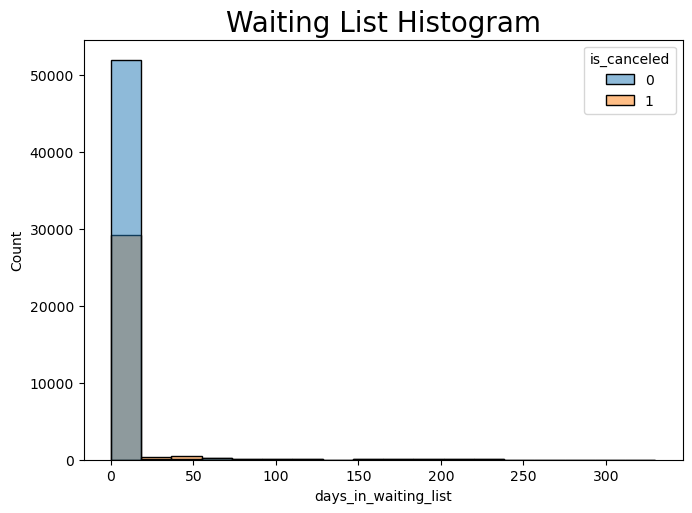

In [50]:
plt.figure(figsize=(17,12))

plt.subplot(221)
sns.histplot(data=df,x='days_in_waiting_list',hue='is_canceled')
plt.title('Waiting List Histogram',fontsize=20)

In [9]:
df.groupby(df['total_of_special_requests']).count()

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,is_canceled
total_of_special_requests,,,,,,,,,,
0,49188,49188,49188,49188,49188,49188,49188,49188,49188,49188
1,23214,23214,23214,23214,23214,23214,23214,23214,23214,23214
2,9120,9120,9120,9120,9120,9120,9120,9120,9120,9120
3,1784,1784,1784,1784,1784,1784,1784,1784,1784,1784
4,236,236,236,236,236,236,236,236,236,236
5,31,31,31,31,31,31,31,31,31,31


In [36]:
df.groupby(df['reserved_room_type']).count()

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,is_canceled
reserved_room_type,,,,,,,,,,
A,59907,59907,59907,59907,59907,59907,59907,59907,59907,59907
B,787,787,787,787,787,787,787,787,787,787
C,673,673,673,673,673,673,673,673,673,673
D,13526,13526,13526,13526,13526,13526,13526,13526,13526,13526
E,4649,4649,4649,4649,4649,4649,4649,4649,4649,4649
F,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037
G,1447,1447,1447,1447,1447,1447,1447,1447,1447,1447
H,401,401,401,401,401,401,401,401,401,401
L,3,3,3,3,3,3,3,3,3,3


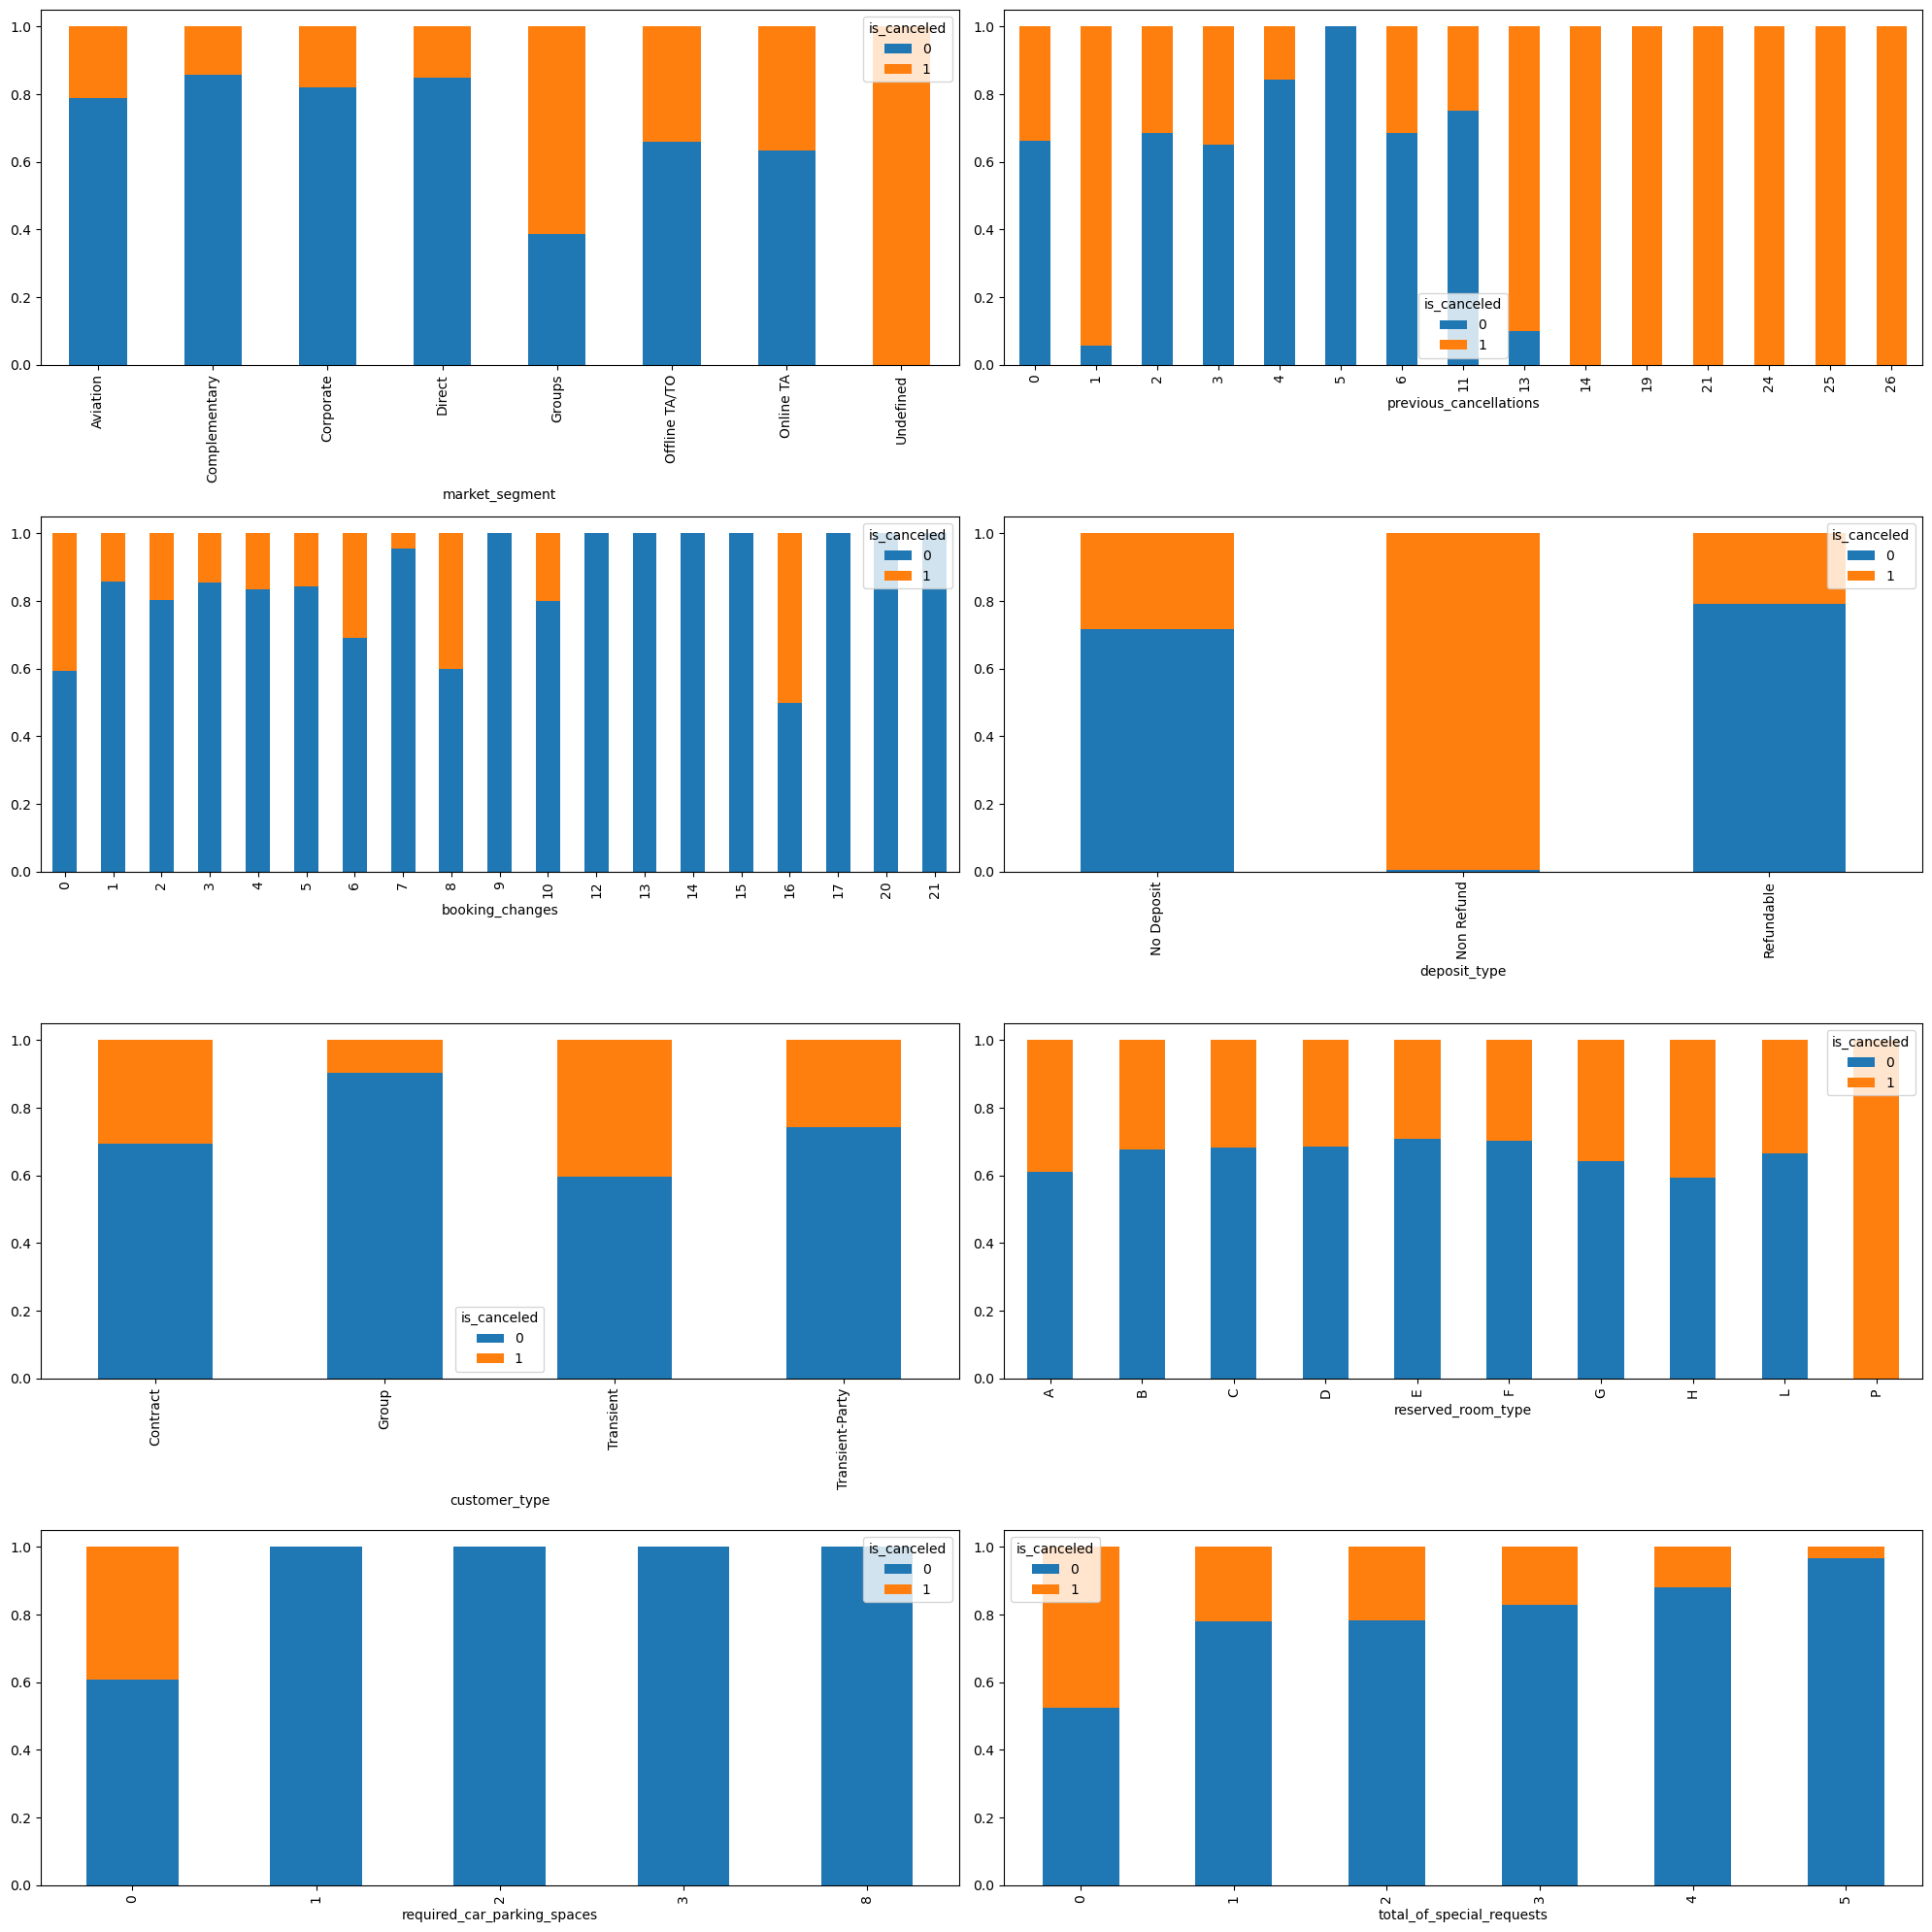

In [11]:
count = 0
fig = plt.figure(figsize=(20,20))

for i in df.drop(columns=['country','days_in_waiting_list','is_canceled']).columns:
    count +=1
    ax= plt.subplot(4,2,count)
    pd.crosstab(df[i],df['is_canceled'],normalize=0).plot(kind='bar',stacked=True,ax=ax)
    fig.tight_layout()

plt.show()

Masih berdasarkan visualisasi data di atas:

- Pada kolom `deposit_rate`, kategori 'non refund' justru memiliki presentase pembatalan paling tinggi jika dibandingkan dengan kategori lain. Ini menarik, karena agak di luar perkiraan. Jika uang tidak dikembalikan (non refund) seharusnya kemungkinan untuk membatalkan justru mengecil, karena pelanggan akan rugi jika membatalkan pesanan yang sudah dibuat.
- Pada kolom `market_segment` terdapat kategori 'Undefined' yang memiiliki presentase pembatalan sangat tinggi. Namun tidak diketahui pastinya seperti apa segmen pasar 'Undefined' ini sehingga tidak dapat dilakukan interpretasi. Perlu dilakukan pengecekan kembali dengan pihak hotel.
- Pada kolom `reserved_room_types` terdapat kategori 'P' yang memiiliki presentase pembatalan sangat tinggi. Namun tidak diketahui pastinya apa yang dimaksud dengan kamar tipe 'P' ini sehingga tidak dapat dilakukan interpretasi. Perlu dilakukan pengecekan kembali dengan pihak hotel.
- Pada kolom `required_car_parking_spaces`, hanya pelanggan yang tidak membutuhkan lahan parkir kendaraan yang berpeluang membatalkan pesanan. Terdapat kemungkinan bahwa pelanggan perlu mengajukan request untuk mendapatkan lahan parkir (tidak semua pelanggan otomatis memndapat lahan parkir), sehingga pelanggan yang secara spesifik mengajukan request untuk lahan parkir adalah pelanggan yang memang sudah pasti berniat untuk menginap di hotel. Namun keterangan ini perlu dikonfirmasi lebih lanjut dengan pihak hotel.
- Pada kolom `total_of_special_requests`, dapat dilihat bahwa semakin banyak special request yang diajukan oleh pelanggan, kemungkinan untuk membatalkan pesanan semakin kecil. Hal ini masuk akal, karena pelanggan yang mengajukan special request kemungkinan besar memang berniat untuk menginap di hotel, dan dengan mengajukan special request, pelanggan pun akan memiliki rasa *engagement* yang lebih tinggi dengan pihak hotel.

In [53]:
df.groupby(df['deposit_type']).describe(include='all')

country                                                        \
               count unique  top   freq mean  std  min  25%  50%  75%  max   
deposit_type                                                                 
No Deposit    73323   163    PRT  24227  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
Non Refund    10006   13     PRT  9742   NaN  NaN  NaN  NaN  NaN  NaN  NaN   
Refundable    110     12     GBR  53     NaN  NaN  NaN  NaN  NaN  NaN  NaN   

             market_segment                                                    \
                      count unique        top   freq mean  std  min  25%  50%   
deposit_type                                                                    
No Deposit    73323          8      Online TA  39413  NaN  NaN  NaN  NaN  NaN   
Non Refund    10006          5      Groups     6296   NaN  NaN  NaN  NaN  NaN   
Refundable    110            5      Groups     91     NaN  NaN  NaN  NaN  NaN   

                       previous_cancellations                            \
              75%  max                  count unique top freq      mean   
deposit_type                                                              
No Deposit    NaN  NaN  73323.0               NaN    NaN NaN   0.036810   
Non Refund    NaN  NaN  10006.0               NaN    NaN NaN   0.247951   
Refundable    NaN  NaN  110.0                 NaN    NaN NaN   0.000000   

                                                 booking_changes             \
                   std  min  25%  50%  75%   max           count unique top   
deposit_type                                                                  
No Deposit    0.339993  0.0  0.0  0.0  0.0  13.0  73323.0        NaN    NaN   
Non Refund    0.448868  0.0  0.0  0.0  0.0  6.0   10006.0        NaN    NaN   
Refundable    0.000000  0.0  0.0  0.0  0.0  0.0   110.0          NaN    NaN   

                                                                 \
             freq      mean       std  min  25%  50%  75%   max   
deposit_type                                                      
No Deposit   NaN   0.249171  0.685350  0.0  0.0  0.0  0.0  21.0   
Non Refund   NaN   0.011793  0.114255  0.0  0.0  0.0  0.0  2.0    
Refundable   NaN   0.609091  0.767403  0.0  0.0  0.0  1.0  3.0    

             days_in_waiting_list                                             \
                            count unique top freq       mean        std  min   
deposit_type                                                                   
No Deposit    73323.0             NaN    NaN NaN   1.457033   14.259867  0.0   
Non Refund    10006.0             NaN    NaN NaN   7.009994   20.870154  0.0   
Refundable    110.0               NaN    NaN NaN   10.027273  37.003461  0.0   

                                   customer_type                          \
              25%  50%  75%    max         count unique              top   
deposit_type                                                               
No Deposit    0.0  0.0  0.0  330.0  73323         4      Transient         
Non Refund    0.0  0.0  0.0  193.0  10006         3      Transient         
Refundable    0.0  0.0  0.0  150.0  110           3      Transient-Party   

                                                       reserved_room_type  \
               freq mean  std  min  25%  50%  75%  max              count   
deposit_type                                                                
No Deposit    53773  NaN  NaN  NaN  NaN  NaN  NaN  NaN  73323               
Non Refund    8842   NaN  NaN  NaN  NaN  NaN  NaN  NaN  10006               
Refundable    93     NaN  NaN  NaN  NaN  NaN  NaN  NaN  110                 

                                                                   \
             unique top   freq mean  std  min  25%  50%  75%  max   
deposit_type                                                        
No Deposit    10     A   50041  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
Non Refund    6      A   9770   NaN  NaN  NaN  NaN 

Kebanyakan pelanggan berjenis 'Transient' dan termasuk segment 'Groups'. Pada grafik pun dapat dilihat segmen pasar 'Groups' merupakan salah satu kategori dengan rasio pembatalan tertinggi dibandingkan dengan segmen lain. Terdapat kemungkinan bahwa pihak hotel memiliki kebijakan tertentu terhadap segmen pasar 'Groups', seperti misalnya segmen ini hanya memiliki opsi untuk membayar deposit yang tidak bisa di refund. Namun informasi pasti mengenai ini tidak diketahui dan perlu dikonfirmasi lebih lanjut dengan pihak hotel.

# Modeling

## Data Prep

Karena terdapat beberapa variabel yang memiliki data dalam bentuk kategorik, maka akan dilakukan proses *encoding* terlebih dulu.
Yang akan dilakukan adalah :

1. Merubah fitur/kolom `country` menggunakan Binary Encoding, karena fitur ini memiliki unique data yang banyak dan tidak memiliki urutan tertentu/tidak ordinal. Bila menggunakan One Hot Encoding akan terlalu banyak fitur baru yang dihasilkan.
3. Merubah fitur/kolom `market_segment` dan `reserved_room_type` juga menggunakan Binary Encoding. Meskipun jumlah data uniknya tidak sebanyak kolom `country`, namun tetap digunakan Binary Encoding dan bukannya One Hot karena jumlah fitur baru yang dihasilkan lebih sedikit jika menggunakan binary encoding dibandingkan dengan One Hot encoding. 
4. Merubah fitur/kolom `deposit_type` dan `customer_type` menggunakan One Hot Encoding, karena fitur ini tidak memiliki urutan/tidak ordinal, dan juga jumlah unique datanya hanya tidak terlalu banyak.

In [19]:
df.columns

Index(['country', 'market_segment', 'previous_cancellations',
       'booking_changes', 'deposit_type', 'days_in_waiting_list',
       'customer_type', 'reserved_room_type', 'required_car_parking_spaces',
       'total_of_special_requests', 'is_canceled'],
      dtype='object')

In [20]:
#feature
X=df.drop(columns = 'is_canceled')
#target
y=df['is_canceled']

In [21]:
#split data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y,test_size=0.2,random_state=1502)

In [22]:
transformer=ColumnTransformer([
    ('one hot encoder', OneHotEncoder(drop='first'),['deposit_type','customer_type']),
    ('binary encoder', ce.BinaryEncoder(),['country','market_segment','reserved_room_type'] )
], remainder='passthrough')

## Selecting Model

Model yang akan coba digunakan terutama Random Forest, XGBoost, dan LGBM, karena ketiga model tersebut cenderung lebih *robust* dalam menghadapi outlier. Namun akan dicoba juga model-model lain untuk klasifikasi seperti Logistic Regression, K-Nearest Neighbor, dan Decision Tree.

In [25]:
#define Model
rf = RandomForestClassifier()
xgb = XGBClassifier()
lgbm = lgb.LGBMClassifier()
logreg = LogisticRegression()
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()

In [57]:
models = [logreg,knn,dt,rf,xgb,lgbm]
score=[]
rata=[]
std=[]

for i in models:
    skfold=StratifiedKFold(n_splits=5)
    estimator=Pipeline([
        ('preprocess',transformer),
        ('model',i)])
    model_cv=cross_val_score(estimator,X_train,y_train,cv=skfold,scoring='roc_auc')
    score.append(model_cv)
    rata.append(model_cv.mean())
    std.append(model_cv.std())
    
pd.DataFrame({'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM'],'mean roc_auc':rata,'sdev':std}).set_index('model').sort_values(by='mean roc_auc',ascending=False)

[LightGBM] [Info] Number of positive: 19615, number of negative: 33785
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009006 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 163
[LightGBM] [Info] Number of data points in the train set: 53400, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.367322 -> initscore=-0.543722
[LightGBM] [Info] Start training from score -0.543722
[LightGBM] [Info] Number of positive: 19615, number of negative: 33786
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005890 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 53401, number of used features: 25
[LightGBM] [Info] [b

,mean roc_auc,sdev
model,,
XGBoost,0.893292,0.001075
LightGBM,0.892903,0.001023
Random Forest,0.887226,0.001897
Decision Tree,0.875955,0.002111
Logistic Regression,0.846161,0.000832
KNN,0.844565,0.002855


Terlihat bahwa model XGBoost memiliki rata-rata roc_auc terbaik di antara keenam model yang menggunakan default hyperparameter.

### Benchmark model with Test Data

In [58]:
models = [logreg,knn,dt,rf,xgb,lgbm]
score_roc_auc = []

def y_pred_func(i):
    estimator=Pipeline([
        ('preprocess',transformer),
        ('model',i)])
    X_train,X_test
    
    estimator.fit(X_train,y_train)
    return(estimator,estimator.predict(X_test),X_test)

for i,j in zip(models, ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost','LightGBM']):
    estimator,y_pred,X_test = y_pred_func(i)
    y_predict_proba = estimator.predict_proba(X_test)[:,1]
    score_roc_auc.append(roc_auc_score(y_test,y_predict_proba))
    print(j,'\n', classification_report(y_test,y_pred))
    
pd.DataFrame({'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost','LightGBM'],
             'roc_auc score':score_roc_auc}).set_index('model').sort_values(by='roc_auc score',ascending=False)

Logistic Regression 
               precision    recall  f1-score   support

           0       0.77      0.93      0.84     10558
           1       0.81      0.51      0.63      6130

    accuracy                           0.78     16688
   macro avg       0.79      0.72      0.73     16688
weighted avg       0.78      0.78      0.76     16688

KNN 
               precision    recall  f1-score   support

           0       0.83      0.84      0.83     10558
           1       0.72      0.69      0.70      6130

    accuracy                           0.79     16688
   macro avg       0.77      0.77      0.77     16688
weighted avg       0.78      0.79      0.79     16688

Decision Tree 
               precision    recall  f1-score   support

           0       0.82      0.89      0.85     10558
           1       0.78      0.67      0.72      6130

    accuracy                           0.81     16688
   macro avg       0.80      0.78      0.79     16688
weighted avg       0.81      0

,roc_auc score
model,
XGBoost,0.895004
LightGBM,0.894016
Random Forest,0.891210
Decision Tree,0.883082
KNN,0.846102
Logistic Regression,0.844535


Pada data test pun XGBoost memiliki roc_auc score tertinggi dibandingkan model-model lain.

## Hyperparameter Tuning

In [59]:
estimator=Pipeline([
    ('preprocess',transformer),
    ('model',xgb)
])

default hyperparameter XGB => `max_depth` = 3, `learning_rate` = 0.1, `n_estimators` = 100\
https://stackoverflow.com/questions/34674797/xgboost-xgbclassifier-defaults-in-python
\
https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [60]:
hyperparam_space=[{
    'model__max_depth': [3, 5, 7],
    'model__learning_rate':[0.01, 0.1, 0.2],
    'model__n_estimators':[100, 500, 1000]
    
}]

In [61]:
grid = GridSearchCV(estimator, n_jobs=-1, param_grid=hyperparam_space, scoring='roc_auc', cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=1502))

In [62]:
grid.fit(X_train,y_train)
print(grid.best_score_)
print(grid.best_params_)

0.8941657223519783
{'model__learning_rate': 0.1, 'model__max_depth': 7, 'model__n_estimators': 500}


Hyperparameter terbaik XGBoost dari hasil Gridsearch => `learning_rate` = 0.1, `max_depth` = 7, `n_estimators` = 500

Untuk hyperparameter `learning_rate` default valuenya tetap yang terbaik, untuk `max_depth` bisa dicoba diperbesar lagi dan dibandingkan dengan 7 (value terbaiknya saat ini), utk `n_estimators` bisa dicoba disekitar angka 500 dan dibandingkan dengan 500 (value terbaiknya saat ini). Namun karena keterbatasan waktu, sementara hyperparameter tuning dicukupkan sampai di sini.

In [71]:
best_model = grid.best_estimator_
best_model.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one hot encoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['deposit_type',
                                                   'customer_type']),
                                                 ('binary encoder',
                                                  BinaryEncoder(),
                                                  ['country', 'market_segment',
                                                   'reserved_room_type'])])),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsampl...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=7, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=500, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [72]:
estimator=Pipeline([
    ('preprocess',transformer),
    ('model',xgb)
])
estimator.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one hot encoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['deposit_type',
                                                   'customer_type']),
                                                 ('binary encoder',
                                                  BinaryEncoder(),
                                                  ['country', 'market_segment',
                                                   'reserved_room_type'])])),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsampl...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [76]:
y_pred_default = estimator.predict(X_test)
y_pred_proba_default = estimator.predict_proba(X_test)
y_pred_tuned = best_model.predict(X_test)
y_pred_proba_tuned = best_model.predict_proba(X_test)

roc_auc_default = roc_auc_score(y_test, y_pred_proba_default[:,1])
roc_auc_tuned = roc_auc_score(y_test, y_pred_proba_tuned[:,1])

print('ROC AUC Score Default XGBoost : ', roc_auc_default)
print('ROC AUC Score Tuned XGBoost : ', roc_auc_tuned)

ROC AUC Score Default XGBoost :  0.8950035877327351
ROC AUC Score Tuned XGBoost :  0.8956370187887801


Terlihat bahwa model XGBoost setelah hyperparameter tuning memiliki nilai ROC AUC yang lebih baik walaupun hanya naik sangat sedikit.

In [77]:
### Markdown Report
report_default = classification_report(y_test, y_pred_default)
report_tuned = classification_report(y_test, y_pred_tuned)

print('Classification Report Default XGBoost : \n', report_default)
print('Classification Report Tuned XGBoost : \n', report_tuned)

Classification Report Default XGBoost : 
               precision    recall  f1-score   support

           0       0.82      0.90      0.86     10558
           1       0.79      0.67      0.72      6130

    accuracy                           0.81     16688
   macro avg       0.81      0.78      0.79     16688
weighted avg       0.81      0.81      0.81     16688

Classification Report Tuned XGBoost : 
               precision    recall  f1-score   support

           0       0.82      0.90      0.86     10558
           1       0.79      0.67      0.72      6130

    accuracy                           0.81     16688
   macro avg       0.81      0.78      0.79     16688
weighted avg       0.81      0.81      0.81     16688



Model XGBoost setelah kita tuning hyperparameternya memiliki classification report yang sama saja dengan sebelum tuning hyperparameter. 

## Feature Importance

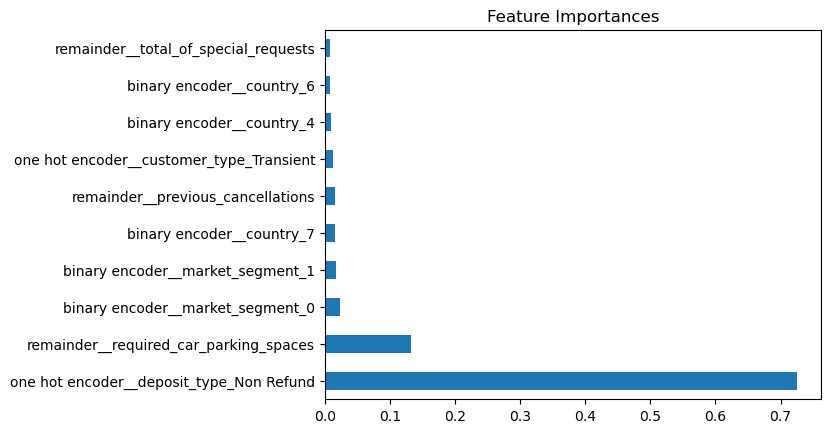

In [69]:
coef1 = pd.Series(best_model['model'].feature_importances_,transformer.get_feature_names_out()).sort_values(ascending = False).head(10)
coef1.plot(kind='barh', title='Feature Importances')
plt.show()

Pada model XGBoost yang telah dibuat, fitur/kolom deposit_type adalah yang paling penting, kemudian diikuti dengan required_car_parking_spaces, dst.

# Conclusion and Recommendation

In [78]:
print('Classification Report Tuned XGBoost : \n', report_tuned)

Classification Report Tuned XGBoost : 
               precision    recall  f1-score   support

           0       0.82      0.90      0.86     10558
           1       0.79      0.67      0.72      6130

    accuracy                           0.81     16688
   macro avg       0.81      0.78      0.79     16688
weighted avg       0.81      0.81      0.81     16688



Berdasarkan hasil classification report dari model yang telah dibuat, dapat disimpulkan bahwa bila seandainya model ini digunakan untuk menyaring pelanggan yang berpotensi membatalkan reservasi agar pihak hotel dapat menghubungi secara personal, maka model ini dapat mengurangi 90% pelanggan yang tidak membatalkan agar tidak perlu dihubungi secara personal, dan model ini dapat mendapatkan 67% pelanggan yang akan membatalkan reservasinya.

Model ini memiliki ketepatan prediksi pelanggan yang akan membatalkan sebesar 79%, jadi setiap model ini memprediksi bahwa seorang pelanggan akan membatalkan reservasi, maka kemungkinan tebakannya benar itu sebesar 79% kurang lebih. Maka masih akan ada pelanggan yang sebenarnya tidak akan membatalkan tetapi diprediksi sebagai pelanggan yang akan membatalkan, yaitu sekitar 10% dari keseluruhan pelanggan yang tidak akan membatalkan reservasi.


### Recommendation

Hal-hal yang bisa dilakukan untuk mengembangkan project dan modelnya lebih baik lagi :
- Membuat kebijakan baru saat pengisian data pelanggan agar mencantumkan negara asalnya
- Mencatat pula kapan seorang pelanggan membatalkan suatu reservasi (berapa hari sebelum tanggal reservasi), durasi menginap, tanggal dibuatnya reservasi, tanggal reservasi yang dipilih untuk mendapatkan lebih banyak insight. Salah satu cara menentukan strategi yang tepat untuk mengatasi pembatalan adalah dengan mengetahui kapan pelanggan akan membatalkan reservasinya
- Mencoba algoritma lain atau melakukan tuning lebih jauh

### Limitations

- Model ini tidak dapat memprediksi pelanggan yang berasal dari negara yang tidak terdapat pada data awal